<a href="https://colab.research.google.com/github/M-S-ibrahim/Generate-Naira-Notes-Synthetic-Using-Generative-Adversarial-Networks/blob/main/C_GAN_MAIN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [24]:
import os
import time
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, Flatten, Dense, Reshape, Concatenate, UpSampling2D, Conv2D, BatchNormalization, LeakyReLU, Activation, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import BinaryCrossentropy
import matplotlib.pyplot as plt

In [25]:
NUM_CLASSES = 8  # Number of Naira denominations (5, 10, 20, 50, 100, 200, 500, 1000)
LATENT_DIM = 128  # Size of the latent noise vector
IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS = 28, 28, 3  # Target image size
BATCH_SIZE = 64  # Batch size for training
EPOCHS = 50  # Number of training epochs
NUM_EXAMPLES_TO_GENERATE = 16  # For visualization

In [26]:
def denomination_generator(latent_dim=LATENT_DIM, num_denominations=NUM_CLASSES, embed_dim=50):
    # Noise input
    noise_input = Input(shape=(latent_dim,), name="noise_input")

    # Label input (integer representing denomination)
    label_input = Input(shape=(1,), dtype='int32', name="denomination_label")
    label_embedding = Embedding(input_dim=num_denominations, output_dim=embed_dim)(label_input)
    label_embedding = Flatten()(label_embedding)

    # Combine noise and label embedding
    combined_input = Concatenate()([noise_input, label_embedding])

    # Project to 7x7x256
    x = Dense(7 * 7 * 256)(combined_input)
    x = BatchNormalization()(x)
    x = LeakyReLU(alpha=0.2)(x)
    x = Reshape((7, 7, 256))(x)

    # Upsampling Block 1: 7x7 -> 14x14
    x = UpSampling2D()(x)
    x = Conv2D(128, kernel_size=5, padding='same')(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(alpha=0.2)(x)

    # Upsampling Block 2: 14x14 -> 28x28
    x = UpSampling2D()(x)
    x = Conv2D(64, kernel_size=5, padding='same')(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(alpha=0.2)(x)

    # Output layer: 28x28x3 image with tanh activation ([-1, 1] range)
    x = Conv2D(3, kernel_size=3, padding='same')(x)
    output = Activation('tanh')(x)

    model = Model(inputs=[noise_input, label_input], outputs=output)
    return model

# Instantiate and check
denomination_generator = denomination_generator()
denomination_generator.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ denomination_label        │ (None, 1)              │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ embedding_2 (Embedding)   │ (None, 1, 50)          │            400 │ denomination_label[0]… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ noise_input (InputLayer)  │ (None, 128)            │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ flatten_3 (Flatten)       │ (None, 50)             │              0 │ embedding_2[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate_2             │ (None, 178)            │              0 │ noise_input[0][0],     │
│ (Concatenate)             │                        │                │ flatten_3[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_3 (Dense)           │ (None, 12544)          │      2,245,376 │ concatenate_2[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_5     │ (None, 12544)          │         50,176 │ dense_3[0][0]          │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ leaky_re_lu_7 (LeakyReLU) │ (None, 12544)          │              0 │ batch_normalization_5… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ reshape_1 (Reshape)       │ (None, 7, 7, 256)      │              0 │ leaky_re_lu_7[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ up_sampling2d_2           │ (None, 14, 14, 256)    │              0 │ reshape_1[0][0]        │
│ (UpSampling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_6 (Conv2D)         │ (None, 14, 14, 128)    │        819,328 │ up_sampling2d_2[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_6     │ (None, 14, 14, 128)    │            512 │ conv2d_6[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ leaky_re_lu_8 (LeakyReLU) │ (None, 14, 14, 128)    │              0 │ batch_normalization_6… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ up_sampling2d_3           │ (None, 28, 28, 128)    │              0 │ leaky_re_lu_8[0][0]    │
│ (UpSampling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_7 (Conv2D)         │ (None, 28, 28, 64)     │        204,864 │ up_sampling2d_3[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_7     │ (None, 28, 28, 64)     │            256 │ conv2d_7[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├──────────────────────

 Total params: 3,322,643 (12.67 MB)

 Trainable params: 3,297,171 (12.58 MB)

 Non-trainable params: 25,472 (99.50 KB)

In [6]:
def discriminator(img_shape=(IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), num_denominations=NUM_CLASSES, embed_dim=50):
    # Image input
    image_input = Input(shape=img_shape, name="image_input")

    # Convolutional layers
    x = Conv2D(64, kernel_size=3, strides=2, padding='same')(image_input)
    x = LeakyReLU(alpha=0.2)(x)
    x = Dropout(0.3)(x)

    x = Conv2D(128, kernel_size=3, strides=2, padding='same')(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(alpha=0.2)(x)
    x = Dropout(0.3)(x)

    x = Conv2D(256, kernel_size=3, strides=2, padding='same')(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(alpha=0.2)(x)
    x = Dropout(0.3)(x)

    flat_image = Flatten()(x)

    # Label input
    label_input = Input(shape=(1,), dtype='int32', name="denomination_label")
    label_embedding = Embedding(input_dim=num_denominations, output_dim=embed_dim)(label_input)
    label_embedding = Flatten()(label_embedding)

    # Combine features
    combined_features = Concatenate()([flat_image, label_embedding])

    x = Dense(512)(combined_features)
    x = LeakyReLU(alpha=0.2)(x)
    x = Dropout(0.3)(x)

    validity_output = Dense(1, activation='sigmoid')(x)

    model = Model(inputs=[image_input, label_input], outputs=validity_output)
    return model

# Instantiate and check
conditional_discriminator = discriminator()
conditional_discriminator.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ image_input (InputLayer)  │ (None, 28, 28, 3)      │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_3 (Conv2D)         │ (None, 14, 14, 64)     │          1,792 │ image_input[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ leaky_re_lu_3 (LeakyReLU) │ (None, 14, 14, 64)     │              0 │ conv2d_3[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout (Dropout)         │ (None, 14, 14, 64)     │              0 │ leaky_re_lu_3[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_4 (Conv2D)         │ (None, 7, 7, 128)      │         73,856 │ dropout[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_3     │ (None, 7, 7, 128)      │            512 │ conv2d_4[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ leaky_re_lu_4 (LeakyReLU) │ (None, 7, 7, 128)      │              0 │ batch_normalization_3… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_1 (Dropout)       │ (None, 7, 7, 128)      │              0 │ leaky_re_lu_4[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_5 (Conv2D)         │ (None, 4, 4, 256)      │        295,168 │ dropout_1[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_4     │ (None, 4, 4, 256)      │          1,024 │ conv2d_5[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ leaky_re_lu_5 (LeakyReLU) │ (None, 4, 4, 256)      │              0 │ batch_normalization_4… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ denomination_label        │ (None, 1)              │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_2 (Dropout)       │ (None, 4, 4, 256)      │              0 │ leaky_re_lu_5[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ embedding_1 (Embedding)   │ (None, 1, 50)          │            400 │ denomination_label[0]… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ flatten_1 (Flatten)       │ (None, 4096)           │              0 │ dropout_2[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ flatten_2 (Flatten)       │ (None, 50)             │              0 │ embedding_1[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate_1             │ (None, 4146)           │              0 │ flatten_1[0][0],       │
│ (Concatenate)             │                        │                │ flatten_2[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_1 (Dense)      

 Total params: 2,496,529 (9.52 MB)

 Trainable params: 2,495,761 (9.52 MB)

 Non-trainable params: 768 (3.00 KB)

In [7]:
def generate_latent_vector(latent_dim, n_samples, n_classes=NUM_CLASSES):
    x_input = np.random.randn(latent_dim * n_samples)
    z_input = x_input.reshape(n_samples, latent_dim)
    labels = np.random.randint(0, n_classes, (n_samples, 1))  # Shape: [n_samples, 1]
    return [z_input, labels]

In [8]:
def generate_fake_samples(generator, latent_dim, n_samples):
    z_input, labels_input = generate_latent_vector(latent_dim, n_samples)
    images = generator.predict([z_input, labels_input])
    y = np.zeros((n_samples, 1))
    return [images, labels_input], y

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 684ms/step


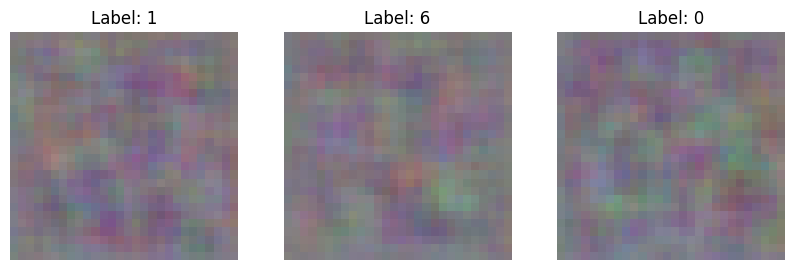

In [9]:
def display_images(images, labels, num_to_display=3):
    fig, axes = plt.subplots(ncols=num_to_display, figsize=(10, 5))
    for i, ax in enumerate(axes):
        img = (images[i] + 1) / 2.0  # Rescale from [-1, 1] to [0, 1]
        ax.imshow(img)
        ax.axis('off')
        ax.set_title(f"Label: {labels[i, 0]}")
    plt.show()

# Test generation and display
[images, labels], _ = generate_fake_samples(denomination_generator, LATENT_DIM, 7)
display_images(images, labels)

In [10]:
BCE_Loss = BinaryCrossentropy(from_logits=False)

def generator_loss(fake_output):
    return BCE_Loss(tf.ones_like(fake_output), fake_output)

def discriminator_loss(real_output, fake_output):
    real_loss = BCE_Loss(tf.ones_like(real_output), real_output)
    fake_loss = BCE_Loss(tf.zeros_like(fake_output), fake_output)
    return real_loss + fake_loss

generator_opt = Adam(learning_rate=0.0002, beta_1=0.5)
discriminator_opt = Adam(learning_rate=0.0002, beta_1=0.5)

In [11]:
import zipfile

zip_file_path = '/content/drive/MyDrive/Colab Notebooks/Datasets/Naira_Notes.zip'

try:
    with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
            # Try to read the contents of the zip file
      print(zip_ref.namelist())
except zipfile.BadZipFile:
    print("The zip file is corrupted.")
except Exception as e:
    print(f"An error occurred: {e}")

['NAIRA DATASET/Test/10/10_1.jpg', 'NAIRA DATASET/Test/10/10_2.jpg', 'NAIRA DATASET/Test/10/10_3.jpeg', 'NAIRA DATASET/Test/10/10_4.jpeg', 'NAIRA DATASET/Test/10/10_5.jpeg', 'NAIRA DATASET/Test/10/10_6.jpeg', 'NAIRA DATASET/Test/10/10_7.jpeg', 'NAIRA DATASET/Test/10/10_8.jpeg', 'NAIRA DATASET/Test/10/10_9.jpeg', 'NAIRA DATASET/Test/100/100_1.JPG', 'NAIRA DATASET/Test/100/100_10.JPG', 'NAIRA DATASET/Test/100/100_11.JPG', 'NAIRA DATASET/Test/100/100_12.JPG', 'NAIRA DATASET/Test/100/100_2.JPG', 'NAIRA DATASET/Test/100/100_3.JPG', 'NAIRA DATASET/Test/100/100_4.JPG', 'NAIRA DATASET/Test/100/100_5.JPG', 'NAIRA DATASET/Test/100/100_6.JPG', 'NAIRA DATASET/Test/100/100_7.JPG', 'NAIRA DATASET/Test/100/100_8.JPG', 'NAIRA DATASET/Test/100/100_9.JPG', 'NAIRA DATASET/Test/1000/1000_1.jpg', 'NAIRA DATASET/Test/1000/1000_10.JPG', 'NAIRA DATASET/Test/1000/1000_11.JPG', 'NAIRA DATASET/Test/1000/1000_12.JPG', 'NAIRA DATASET/Test/1000/1000_2.jpg', 'NAIRA DATASET/Test/1000/1000_3.jpg', 'NAIRA DATASET/Test/

In [12]:
# Specify the path to the zip file and the extraction directory
zip_file_path = "/content/drive/MyDrive/Colab Notebooks/Datasets/Naira_Notes.zip"
extract_dir = "/content/extracted_files"  # Corrected path to a directory

# Create the extraction directory if it doesn't exist
os.makedirs(extract_dir, exist_ok=True)

# Unzip the file
try:
    with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
        zip_ref.extractall(extract_dir)
    print(f"Successfully unzipped {zip_file_path} to {extract_dir}")
except FileNotFoundError:
    print(f"Error: {zip_file_path} not found.")
except zipfile.BadZipFile:
    print(f"Error: {zip_file_path} is not a valid zip file.")
except Exception as e:
    print(f"An unexpected error occurred: {e}")

Successfully unzipped /content/drive/MyDrive/Colab Notebooks/Datasets/Naira_Notes.zip to /content/extracted_files


In [13]:
Train = '/content/extracted_files/NAIRA DATASET/Train'
Test = '/content/extracted_files/NAIRA DATASET/Test'
Val = '/content/extracted_files/NAIRA DATASET/val'
Train

'/content/extracted_files/NAIRA DATASET/Train'

In [14]:
def load_image_paths_and_labels(train_dir):
    # Example label mapping (adjust based on actual denominations)
    label_mapping = {'5': 0, '10': 1, '20': 2, '50': 3, '100': 4, '200': 5, '500': 6, '1000': 7}
    image_paths = []
    labels = []
    for denom in os.listdir(train_dir):
        denom_path = os.path.join(train_dir, denom)
        if os.path.isdir(denom_path):
            for img_file in os.listdir(denom_path):
                image_paths.append(os.path.join(denom_path, img_file))
                labels.append(label_mapping[denom])
    return image_paths, labels

def preprocess_image(image_path, label):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_jpeg(image, channels=IMG_CHANNELS)
    image = tf.image.resize(image, [IMG_HEIGHT, IMG_WIDTH])
    image = (image / 127.5) - 1.0  # Normalize to [-1, 1]
    return image, tf.expand_dims(label, axis=-1)  # Label shape: [1]

def create_dataset(image_paths, labels, batch_size, shuffle=True):
    dataset = tf.data.Dataset.from_tensor_slices((image_paths, labels))
    dataset = dataset.map(preprocess_image, num_parallel_calls=tf.data.AUTOTUNE)
    if shuffle:
        dataset = dataset.shuffle(buffer_size=1000)
    dataset = dataset.batch(batch_size).prefetch(tf.data.AUTOTUNE)
    return dataset

# Example usage (replace 'TRAIN_DIR' with actual path)
TRAIN_DIR = Train
image_paths, labels = load_image_paths_and_labels(TRAIN_DIR)
dataset = create_dataset(image_paths, labels, BATCH_SIZE)

In [15]:
@tf.function
def train_step(real_images, true_labels):
    batch_size = tf.shape(real_images)[0]
    noise = tf.random.normal([batch_size, LATENT_DIM])
    generated_labels = tf.random.uniform([batch_size, 1], minval=0, maxval=NUM_CLASSES, dtype=tf.int32)

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = denomination_generator([noise, generated_labels], training=True)
        real_output = conditional_discriminator([real_images, true_labels], training=True)
        fake_output = conditional_discriminator([generated_images, generated_labels], training=True)
        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, denomination_generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, conditional_discriminator.trainable_variables)

    generator_opt.apply_gradients(zip(gradients_of_generator, denomination_generator.trainable_variables))
    discriminator_opt.apply_gradients(zip(gradients_of_discriminator, conditional_discriminator.trainable_variables))
    return gen_loss, disc_loss

In [16]:
# Seed for consistent visualization
seed_noise, seed_labels = generate_latent_vector(LATENT_DIM, NUM_EXAMPLES_TO_GENERATE)
# Convert seed_noise to a TensorFlow tensor
seed_noise = tf.convert_to_tensor(seed_noise, dtype=tf.float32)  # Ensure it's the correct dtype
seed_labels = tf.convert_to_tensor(seed_labels)

In [17]:
def generate_and_save_images(generator, epoch, seed_noise, seed_labels, save_dir='generated_images'):
    # Both inputs are now tensors
    predictions = generator([seed_noise, seed_labels], training=False)
    fig = plt.figure(figsize=(16, 4))
    for i in range(predictions.shape[0]):
        plt.subplot(2, 8, i+1)
        img = (predictions[i] + 1) / 2.0  # Rescale to [0, 1]
        plt.imshow(img)
        plt.title(f"Label: {seed_labels[i, 0]}")
        plt.axis('off')
    os.makedirs(save_dir, exist_ok=True)
    plt.savefig(os.path.join(save_dir, f'epoch_{epoch:04d}.png'))
    plt.close()
    plt.show()

In [18]:
# Checkpointing setup
checkpoint_dir = './checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator=denomination_generator,
                                 discriminator=conditional_discriminator,
                                 generator_opt=generator_opt,
                                 discriminator_opt=discriminator_opt)

In [27]:
def train(dataset, epochs):
    for epoch in range(epochs):
        start = time.time()
        for image_batch, label_batch in dataset:
            gen_loss, disc_loss = train_step(image_batch, label_batch)

        print(f'Epoch {epoch+1}/{EPOCHS}, '
              f'Gen Loss: {gen_loss.numpy():.4f}, '
              f'Disc Loss: {disc_loss.numpy():.4f}, '
              f'Time: {time.time()-start:.2f} sec')

        # Generate and save images
        generate_and_save_images(denomination_generator, epoch+1, seed_noise, seed_labels)

        # Save checkpoint every 15 epochs
        if (epoch + 1) % 15 == 0:
            checkpoint.save(file_prefix=checkpoint_prefix)

    # Final generation
    generate_and_save_images(denomination_generator, epochs, seed_noise, seed_labels)

# Run training
train(dataset, EPOCHS)

Epoch 1/50, Gen Loss: 1.4705, Disc Loss: 0.8465, Time: 93.23 sec
Epoch 2/50, Gen Loss: 0.4547, Disc Loss: 2.2920, Time: 91.84 sec
Epoch 3/50, Gen Loss: 1.8158, Disc Loss: 2.2049, Time: 91.84 sec
Epoch 4/50, Gen Loss: 0.9516, Disc Loss: 0.9902, Time: 91.35 sec
Epoch 5/50, Gen Loss: 1.4816, Disc Loss: 0.6640, Time: 91.24 sec
Epoch 6/50, Gen Loss: 0.9983, Disc Loss: 1.4899, Time: 93.04 sec
Epoch 7/50, Gen Loss: 1.2769, Disc Loss: 1.0789, Time: 91.08 sec
Epoch 8/50, Gen Loss: 1.4112, Disc Loss: 0.9509, Time: 91.39 sec
Epoch 9/50, Gen Loss: 1.7794, Disc Loss: 1.1141, Time: 92.33 sec
Epoch 10/50, Gen Loss: 2.5922, Disc Loss: 0.7544, Time: 92.82 sec
Epoch 11/50, Gen Loss: 1.1397, Disc Loss: 1.0918, Time: 92.56 sec
Epoch 12/50, Gen Loss: 2.5257, Disc Loss: 0.2264, Time: 90.64 sec
Epoch 13/50, Gen Loss: 0.9487, Disc Loss: 0.9938, Time: 91.21 sec
Epoch 14/50, Gen Loss: 2.8451, Disc Loss: 0.7290, Time: 93.13 sec
Epoch 15/50, Gen Loss: 1.9553, Disc Loss: 1.3670, Time: 91.38 sec
Epoch 16/50, Gen Lo

In [34]:
# Save the model with the .keras extension
denomination_generator.save('denomination_generator_model.keras')
conditional_discriminator.save('conditional_discriminator_model.keras')

# Optionally, you can use the .h5 extension:
# denomination_generator.save('denomination_generator_model.h5')
# conditional_discriminator.save('conditional_discriminator_model.h5')

In [28]:
Test_DIR = Test
Test_image_paths, Test_labels = load_image_paths_and_labels(Test_DIR)
Test_dataset = create_dataset(Test_image_paths, Test_labels, BATCH_SIZE)

In [30]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

In [31]:
# Initialize lists to collect predictions and labels
real_predictions = []
real_true_labels = []

# Get predictions on real images from Test_dataset
for images, denom_labels in Test_dataset:
    preds = conditional_discriminator.predict([images, denom_labels])  # Shape: (batch_size, 1)
    real_predictions.append(preds)  # Keep as 2D
    real_true_labels.extend([1] * images.shape[0])  # Label 1 for real images

# Stack real predictions into a single 2D array
real_predictions = np.vstack(real_predictions)  # Shape: (total_real_samples, 1)

# Generate fake images (adjust n_fake and parameters as per your setup)
n_fake = len(Test_image_paths)  # Example: match number of real images
noise = tf.random.normal([n_fake, LATENT_DIM])  # LATENT_DIM should be defined
fake_denom_labels = tf.random.uniform([n_fake, 1], minval=0, maxval=NUM_CLASSES, dtype=tf.int32)  # NUM_CLASSES should be defined
fake_images = denomination_generator.predict([noise, fake_denom_labels])

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 300ms/step


In [29]:
# Get predictions on fake images
fake_predictions = conditional_discriminator.predict([fake_images, fake_denom_labels])  # Shape: (n_fake, 1)
fake_true_labels = [0] * n_fake  # Label 0 for fake images

# Combine predictions and true labels
all_predictions = np.concatenate([real_predictions, fake_predictions], axis=0)  # Shape: (total_samples, 1)
all_true_labels = np.array(real_true_labels + fake_true_labels)  # Shape: (total_samples,)

# Convert predictions to binary classes (0 or 1)
predicted_classes = (all_predictions > 0.5).astype(int).flatten()  # Shape: (total_samples,)

# Calculate evaluation metrics
accuracy = accuracy_score(all_true_labels, predicted_classes)
precision = precision_score(all_true_labels, predicted_classes)
recall = recall_score(all_true_labels, predicted_classes)
f1 = f1_score(all_true_labels, predicted_classes)

# Print results
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1:.4f}")

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 699ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Accuracy: 0.9667
Precision: 1.0000
Recall: 0.9333
F1-Score: 0.9655


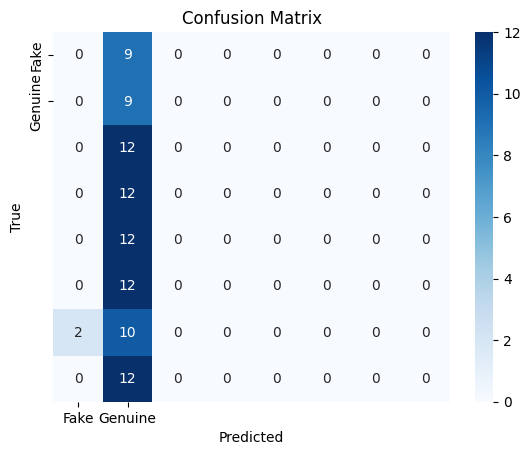

In [32]:
cm = confusion_matrix(true_labels, predictions)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Fake', 'Genuine'], yticklabels=['Fake', 'Genuine'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()